In [6]:
import pennylane as qml
from pennylane import numpy as np

def jw_term(i, j, theta):
    """Jordan-Wigner term a†_i a_j using Pauli operators."""
    if i == j:
        return None, None  # skip diagonal terms

    # Determine order for Z string
    z_range = range(min(i, j) + 1, max(i, j))
    z_string = [qml.PauliZ(k) for k in z_range]

    # Build the hopping term (X - iY)(X + iY) / 4 = (XX + YY)/2
    if i < j:
        op1 = qml.PauliX(i) @ qml.PauliX(j)
        op2 = qml.PauliY(i) @ qml.PauliY(j)
        phase = np.exp(-1j * theta)
    else:
        op1 = qml.PauliX(j) @ qml.PauliX(i)
        op2 = qml.PauliY(j) @ qml.PauliY(i)
        phase = np.exp(1j * theta)

    # Apply Z string
    if z_string:
        z_op = z_string[0]
        for z in z_string[1:]:
            z_op = z_op @ z
        op1 = z_op @ op1
        op2 = z_op @ op2

    return [phase / 2, phase / 2], [op1, op2]

def build_hamiltonian(edges, theta, n_qubits):
    """Construct total Hamiltonian from edge list."""
    coeffs = []
    ops = []

    for i, j in edges:
        i -= 1  # convert to 0-based
        j -= 1
        c, o = jw_term(i, j, theta)
        if c is not None:
            coeffs.extend(c)
            ops.extend(o)

    return qml.Hamiltonian(coeffs, ops)

# Example usage
edges = [(1, 2), (2, 3), (2, 4), (1, 3), (3, 4)]
theta = np.pi / 4
n_qubits = 4

H = build_hamiltonian(edges, theta, n_qubits)
print(H)


(0.3535533905932738-0.35355339059327373j) * (X(0) @ X(1)) + (0.3535533905932738-0.35355339059327373j) * (Y(0) @ Y(1)) + (0.3535533905932738-0.35355339059327373j) * (X(1) @ X(2)) + (0.3535533905932738-0.35355339059327373j) * (Y(1) @ Y(2)) + (0.3535533905932738-0.35355339059327373j) * (Z(2) @ X(1) @ X(3)) + (0.3535533905932738-0.35355339059327373j) * (Z(2) @ Y(1) @ Y(3)) + (0.3535533905932738-0.35355339059327373j) * (Z(1) @ X(0) @ X(2)) + (0.3535533905932738-0.35355339059327373j) * (Z(1) @ Y(0) @ Y(2)) + (0.3535533905932738-0.35355339059327373j) * (X(2) @ X(3)) + (0.3535533905932738-0.35355339059327373j) * (Y(2) @ Y(3))


In [47]:
import pennylane as qml
from pennylane.fermi import FermiC, FermiA, jordan_wigner
from pennylane import numpy as np


def print_ket(state, threshold=1e-6):
    n_qubits = int(np.log2(len(state)))
    for i, amp in enumerate(state):
        if np.abs(amp) > threshold:
            print(f"{amp:.4g} |{format(i, f'0{n_qubits}b')}⟩")

# Number of orbitals (qubits)
N = 4

# Define creation and annihilation operators
a1d = FermiC(0)
a2d = FermiC(1)
a3  = FermiA(2)
a4  = FermiA(3)

# Compose operator expression
expr = a2d * a1d

# Apply Jordan-Wigner transform to map to qubit ops
qubit_op = jordan_wigner(expr)

print(qubit_op)

mat = qml.matrix(qubit_op, wire_order=range(N))

# Build vacuum state |0000⟩
zero = np.array([1, 0])
vacuum = zero
for _ in range(N - 1):
    vacuum = np.kron(vacuum, zero)

psi_0 = mat @ vacuum

print_ket(psi_0)

# Compute amplitude
#amp = vacuum.conj().T @ mat @ vacuum
#print("⟨0| a₃ a₄ a₂† a₁† |0⟩ =", amp)


0.25j * (Y(0) @ X(1)) + (-0.25+0j) * (X(0) @ X(1)) + (0.25+0j) * (Y(0) @ Y(1)) + 0.25j * (X(0) @ Y(1))
-1+0j |1100⟩


In [48]:
import pennylane as qml
from pennylane import numpy as np

def anyonic_creation(x, N, phi):
    """Anyonic creation operator a†_x on N qubits with statistical phase phi."""
    eta = np.exp(-1j * phi)  # for creation operator
    prefactor = []
    for x_prime in range(x):
        term = (eta + 1) / 2 * qml.Identity(x_prime) + (eta - 1) / 2 * qml.PauliZ(x_prime)
        prefactor.append(term)

    # Combine with σ⁺ = (X - iY)/2
    sigma_plus = (qml.PauliX(x) - 1j * qml.PauliY(x)) / 2

    # Build full operator
    op = sigma_plus
    for factor in reversed(prefactor):
        op = factor @ op
    return op

def anyonic_annihilation(x, N, phi):
    """Anyonic annihilation operator a_x on N qubits with statistical phase phi."""
    eta = np.exp(1j * phi)  # for annihilation operator
    prefactor = []
    for x_prime in range(x):
        term = (eta + 1) / 2 * qml.Identity(x_prime) + (eta - 1) / 2 * qml.PauliZ(x_prime)
        prefactor.append(term)

    # Combine with σ⁻ = (X + iY)/2
    sigma_minus = (qml.PauliX(x) + 1j * qml.PauliY(x)) / 2

    # Build full operator
    op = sigma_minus
    for factor in reversed(prefactor):
        op = factor @ op
    return op


In [50]:
N = 4
phi = np.pi  # Jordan-Wigner case

a1d = anyonic_creation(0, N, phi)
a2d = anyonic_creation(1, N, phi)
a3  = anyonic_annihilation(2, N, phi)
a4  = anyonic_annihilation(3, N, phi)

# Full 4-fermion expression: a₃ a₄ a₂† a₁†
op = a2d @ a1d

# Convert to matrix
mat = qml.matrix(op, wire_order=range(N))

psi = mat @ vacuum

print_ket(psi)


1+0j |1100⟩


In [70]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fermi import FermiC, FermiA, jordan_wigner
from pennylane import Identity, PauliZ

# Parameters
theta = 0.5
t = 2.0
N = 4

In [71]:
edges = [(1, 2), (2, 3), (2, 4), (1, 3), (3, 4)]
nodes = sorted(set(i for edge in edges for i in edge))

import networkx as nx
g = nx.Graph()
g.add_edges_from(edges)

def jw_path(i, j):
    path = nx.shortest_path(g, i, j)
    return path[1:-1] if len(path) > 2 else []

# Build unique (i, j, path) triples
pairs = [(i, j) for i in nodes for j in nodes if i < j]
triples = [(i, j, jw_path(i, j)) for (i, j) in pairs]

In [77]:
def sigma_dagger(k, theta):
    a_k_dag = FermiC(k)
    a_k = FermiA(k)
    n_k = a_k_dag * a_k
    id_op = qml.fermi.FermiSentence({})
    z_k = id_op - 2 * n_k  # Z = I - 2 a†a

    term_I = 0.5 * np.exp(1 + 1j * theta) * id_op
    term_Z = 0.5 * np.exp(-1 + 1j * theta) * z_k
    return term_I + term_Z

coeffs = []
ops = []

for i, j, path in triples:
    i_idx = i - 1
    j_idx = j - 1
    a_i_dag = FermiC(i_idx)
    a_j = FermiA(j_idx)

    sigmas = [sigma_dagger(k - 1, theta) for k in reversed(path)]

    f_op = a_i_dag
    for s in sigmas:
        f_op = f_op * s
    f_op = f_op * a_j

    qubit_op = jordan_wigner(f_op)
    ops.extend([qubit_op, qubit_op.adjoint()])
    coeffs.extend([1.0, 1.0])


H = qml.Hamiltonian(coeffs, ops)
Hmat = qml.matrix(H, wire_order=range(N))


In [78]:
zero = np.array([1, 0])
one = np.array([0, 1])

psi0 = np.zeros(2**N)
psi0[12] = 1.0

print("Initial state:")
print_ket(psi0)

U = qml.math.expm(-1j * Hmat * t)
psi_t = U @ psi0

occupied_indices = [12, 13, 14, 15]
prob = sum(np.abs(psi_t[i])**2 for i in occupied_indices)
print("Probability qubits 3 & 4 occupied:", prob)


Initial state:
1 |1100⟩
Probability qubits 3 & 4 occupied: 0.003029538129907112


In [119]:
import pennylane as qml
from pennylane.fermi import FermiC, FermiA, jordan_wigner
import networkx as nx
import numpy as np

# Parameters
phi = 0.5  # Aharonov-Bohm phase
eta = np.exp(1j * phi)  # Phase factor
N = 4  # Number of sites
edges = [(1, 2), (2, 3), (2, 4), (1, 3), (3, 4)]
red_link = (2, 4)  # Phase is only on this edge

# Build connectivity graph
G = nx.Graph()
G.add_edges_from(edges)

# Define path function between qubits
def jw_path(i, j):
    path = nx.shortest_path(G, i, j)
    return path[1:-1] if len(path) > 2 else []

# Get unique i<j with paths
nodes = sorted(set(i for e in edges for i in e))
triples = [(i, j, jw_path(i, j)) for i in nodes for j in nodes if i < j]

# Anyonic Sigma dagger operator (fermionic version)
def sigma_dagger(k, theta):
    a_k_dag = FermiC(k)
    a_k = FermiA(k)
    n_k = a_k_dag * a_k
    id_op = qml.fermi.FermiSentence({})
    z_k = id_op - 2 * n_k
    term_I = 0.5 * np.exp(1 + 1j * theta) * id_op
    term_Z = 0.5 * np.exp(-1 + 1j * theta) * z_k
    return term_I + term_Z

# Build Hamiltonian using Jordan-Wigner transformation
coeffs = []
ops = []

for (i, j, path) in triples:
    i_idx = i - 1
    j_idx = j - 1
    a_i_dag = FermiC(i_idx)
    a_j = FermiA(j_idx)

    phase = eta if (i, j) == red_link or (j, i) == red_link else 1.0

    # Build Sigma dagger product along path
    sigmas = [sigma_dagger(k - 1, phi) for k in reversed(path)]

    f_op = a_i_dag
    for s in sigmas:
        f_op = f_op * s
    f_op = f_op * a_j
    f_op *= phase

    qubit_op = jordan_wigner(f_op)
    ops.extend([qubit_op, qubit_op.adjoint()])
    coeffs.extend([1.0, 1.0])

# Add interaction terms: n_i n_j
V = 1.0  # Interaction strength
for i in range(N):
    for j in range(i + 1, N):
        ni = FermiC(i) * FermiA(i)
        nj = FermiC(j) * FermiA(j)
        f_interaction = ni * nj
        qubit_op = jordan_wigner(f_interaction)
        ops.append(qubit_op)
        coeffs.append(V)

# Hamiltonian
H = qml.Hamiltonian(coeffs, ops)

# Iterate over each term in the Hamiltonian and print the Pauli string
for i, op in enumerate(H.ops):
    print(f"Pauli string of term {i+1}: {op}")


Pauli string of term 1: -0.25j * (Y(0) @ X(1)) + (0.25+0j) * (Y(0) @ Y(1)) + (0.25+0j) * (X(0) @ X(1)) + 0.25j * (X(0) @ Y(1))
Pauli string of term 2: Adjoint(-0.25j * (Y(0) @ X(1))) + Adjoint((0.25+0j) * (Y(0) @ Y(1))) + Adjoint((0.25+0j) * (X(0) @ X(1))) + Adjoint(0.25j * (X(0) @ Y(1)))
Pauli string of term 3: -0.25j * (Y(0) @ Z(1) @ X(2)) + (0.25+0j) * (Y(0) @ Z(1) @ Y(2)) + (0.25+0j) * (X(0) @ Z(1) @ X(2)) + 0.25j * (X(0) @ Z(1) @ Y(2))
Pauli string of term 4: Adjoint(-0.25j * (Y(0) @ Z(1) @ X(2))) + Adjoint((0.25+0j) * (Y(0) @ Z(1) @ Y(2))) + Adjoint((0.25+0j) * (X(0) @ Z(1) @ X(2))) + Adjoint(0.25j * (X(0) @ Z(1) @ Y(2)))
Pauli string of term 5: (-0.022046349903128995+0.04035557280625413j) * (Y(0) @ Z(1) @ Z(2) @ X(3)) + (-0.04035557280625413-0.022046349903128995j) * (Y(0) @ Z(1) @ Z(2) @ Y(3)) + (0.022046349903128995-0.04035557280625413j) * (Y(0) @ Z(2) @ X(3)) + (0.04035557280625413+0.022046349903128995j) * (Y(0) @ Z(2) @ Y(3)) + (-0.04035557280625413-0.022046349903128995j) * (

In [120]:
# Initial state |1100>
psi0 = np.zeros(2**N)
psi0[12] = 1.0  # |1100> = index 12 in little-endian (q3 q2 q1 q0)

# Time evolution
U = qml.math.expm(-1j * Hmat * t)
psi_t = U @ psi0

# Measure probability of occupation on qubits 3 & 4 (i.e. qubit indices 2,3)
occupied_indices = [12, 13, 14, 15]  # |1100|1101|1110|1111
prob = sum(np.abs(psi_t[i])**2 for i in occupied_indices)

print("Probability qubits 3 & 4 occupied:", prob)

# Optional: check Hermiticity
print("H is Hermitian:", np.allclose(Hmat, Hmat.conj().T))

Probability qubits 3 & 4 occupied: 0.5320419233060598
H is Hermitian: True


In [113]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx

# PARAMETERS
phi = 0.5
theta = np.pi / 2
N = 4
edges = [(1, 2), (2, 3), (2, 4), (1, 3), (3, 4)]
eta = np.exp(1j * theta)

# GRAPH FOR PATHS
G = nx.Graph()
G.add_edges_from(edges)
nodes = sorted(set(i for e in edges for i in e))

def jw_path(i, j):
    path = nx.shortest_path(G, i, j)
    return path[1:-1] if len(path) > 2 else []

def sigma_numeric(k, theta):
    return (
        0.5 * np.exp(-1j * theta + 1) * qml.Identity(k)
        + 0.5 * np.exp(-1j * theta - 1) * qml.PauliZ(k)
    )

# PRODUCT OF SIGMA OPERATORS OVER A PATH
def sigma_string(indices, theta):
    if not indices:
        return qml.Identity(0)
    result = sigma_numeric(indices[0], theta)
    for k in indices[1:]:
        result = result @ sigma_numeric(k, theta)
    return result

# def create_numeric(j, theta):
#     sigma_prod = sigma_string(range(j), theta)
#     return sigma_prod @ qml.PauliX(j)

# def annihilate_numeric(j, theta):
#     sigma_prod = sigma_string(range(j), theta)
#     return sigma_prod @ qml.PauliX(j)

def SP(k):  # σ₊
    return 0.5 * (qml.PauliX(k) - 1j * qml.PauliY(k))

def SM(k):  # σ₋
    return 0.5 * (qml.PauliX(k) + 1j * qml.PauliY(k))

# TWO-BODY TERM WITH PATH
# def two_body_path_numeric(i, j, path, theta):
#     sigma_path = sigma_string(path, theta)
#     sp_i = qml.PauliX(i)
#     sm_j = qml.PauliX(j)
#     return sp_i @ sigma_path.adjoint() @ sm_j

def two_body_path_numeric(i, j, path, theta):
    sigma_path = sigma_string(path, theta)
    sp_i = SP(i)
    sm_j = SM(j)
    return sp_i @ sigma_path.adjoint() @ sm_j

# COLLECT PATHS AND BUILD TERMS
triples = [(i, j, jw_path(i, j)) for i in nodes for j in nodes if i < j]

ops = []
coeffs = []

for i, j, path in triples:
    A = two_body_path_numeric(i - 1, j - 1, [k - 1 for k in path], theta)
    
    # Apply AB phase if it's edge (2,4)
    phase = eta if (i, j) == (2, 4) or (j, i) == (2, 4) else 1.0

    ops.append(A)
    coeffs.append(phase)

    ops.append(A.adjoint())
    coeffs.append(np.conj(phase))

# BUILD HAMILTONIAN
H = qml.Hamiltonian(coeffs, ops)

# SHOW TERMS
print("Pauli Strings in Hamiltonian:")
for i, op in enumerate(H.ops):
    print(f"Term {i+1}: {op}    Coeff: {coeffs[i]}")

# HAMILTONIAN MATRIX
Hmat = qml.matrix(H, wire_order=range(N))
print("\nIs H Hermitian?", np.allclose(Hmat, Hmat.conj().T))


Pauli Strings in Hamiltonian:
Term 1: (0.5 * (X(0) + (-0-1j) * Y(0))) @ I(0) @ (0.5 * (X(1) + 1j * Y(1)))    Coeff: 1.0
Term 2: (Adjoint(0.5 * (X(1) + 1j * Y(1)))) @ (Adjoint(I(0))) @ (Adjoint(0.5 * (X(0) + (-0-1j) * Y(0))))    Coeff: 1.0
Term 3: (0.5 * (X(0) + (-0-1j) * Y(0))) @ I(0) @ (0.5 * (X(2) + 1j * Y(2)))    Coeff: 1.0
Term 4: (Adjoint(0.5 * (X(2) + 1j * Y(2)))) @ (Adjoint(I(0))) @ (Adjoint(0.5 * (X(0) + (-0-1j) * Y(0))))    Coeff: 1.0
Term 5: (0.5 * (X(0) + (-0-1j) * Y(0))) @ (Adjoint((8.32233785100696e-17-1.3591409142295225j) * I(1)) + Adjoint((1.1263059502568097e-17-0.18393972058572117j) * Z(1))) @ (0.5 * (X(3) + 1j * Y(3)))    Coeff: 1.0
Term 6: (Adjoint(0.5 * (X(3) + 1j * Y(3)))) @ (Adjoint(Adjoint((8.32233785100696e-17-1.3591409142295225j) * I(1)) + Adjoint((1.1263059502568097e-17-0.18393972058572117j) * Z(1)))) @ (Adjoint(0.5 * (X(0) + (-0-1j) * Y(0))))    Coeff: 1.0
Term 7: (0.5 * (X(1) + (-0-1j) * Y(1))) @ I(0) @ (0.5 * (X(2) + 1j * Y(2)))    Coeff: 1.0
Term 8: (Adjoin

In [118]:
psi0 = np.zeros(2**N, dtype=complex)
psi0[12] = 1.0  # |1100⟩ in little-endian = index 12 (q3 q2 q1 q0)

# Time evolution
U = qml.math.expm(-1j * Hmat * t)
psi_t = U @ psi0

# Probability qubits 3 & 4 (i.e., q2 and q3) are occupied
# Indices 12, 13, 14, 15 correspond to |11**⟩
occupied_indices = [12, 13, 14, 15]
prob = sum(np.abs(psi_t[i])**2 for i in occupied_indices)

# ───────────────────────────────────────────────
# 🔎 RESULTS
print("Probability qubits 3 & 4 (sites 3 and 4) are occupied:", prob)
print("H is Hermitian:", np.allclose(Hmat, Hmat.conj().T))

Probability qubits 3 & 4 (sites 3 and 4) are occupied: 0.5320419233060598
H is Hermitian: True


Difference in probabilities between φ = 0 and φ = π:
[0.         0.         0.         0.46176653 0.         0.11037372
 0.03723939 0.         0.         0.03723939 0.17497626 0.
 0.67263773 0.         0.         0.        ]


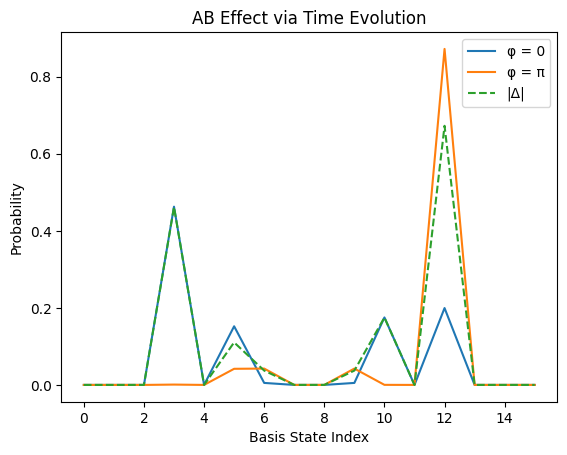

In [115]:
def evolve_and_measure(phi):
    theta = phi
    eta = np.exp(1j * theta)

    # build Hamiltonian with given phase
    ops, coeffs = [], []
    for i, j, path in triples:
        A = two_body_path_numeric(i - 1, j - 1, [k - 1 for k in path], theta)
        phase = eta if (i, j) == (2, 4) or (j, i) == (2, 4) else 1.0
        ops.append(A)
        coeffs.append(phase)
        ops.append(A.adjoint())
        coeffs.append(np.conj(phase))
    H = qml.Hamiltonian(coeffs, ops)

    # evolve |1100⟩
    psi0 = np.zeros(2**N, dtype=complex)
    psi0[12] = 1.0  # |1100⟩

    U = qml.math.expm(-1j * qml.matrix(H, wire_order=range(N)) * t)
    psi_t = U @ psi0

    # probability distribution over all states
    probs = np.abs(psi_t)**2
    return probs

# Run with φ = 0 and φ = π
probs_phi0 = evolve_and_measure(phi=0.0)
probs_phiPi = evolve_and_measure(phi=np.pi)

# Compare distributions
delta = np.abs(probs_phi0 - probs_phiPi)
print("Difference in probabilities between φ = 0 and φ = π:")
print(delta)

# Optional: plot the distributions
import matplotlib.pyplot as plt

x = np.arange(2**N)
plt.plot(x, probs_phi0, label="φ = 0")
plt.plot(x, probs_phiPi, label="φ = π")
plt.plot(x, delta, label="|Δ|", linestyle="--")
plt.xlabel("Basis State Index")
plt.ylabel("Probability")
plt.legend()
plt.title("AB Effect via Time Evolution")
plt.show()


In [116]:
triples = [(i, j, jw_path(i, j)) for i in nodes for j in nodes if i < j]

ops = []
coeffs = []

print("Hamiltonian Terms with Paths:\n")

for idx, (i, j, path) in enumerate(triples):
    i0, j0 = i - 1, j - 1  # 0-based
    path0 = [k - 1 for k in path]

    A = two_body_path_numeric(i0, j0, path0, theta)

    # AB phase only for edge (2, 4)
    phase = eta if (i, j) == (2, 4) or (j, i) == (2, 4) else 1.0

    print(f"Pair ({i},{j}): JW path = {path}, wires = ({i0}->{j0})")

    ops.append(A)
    coeffs.append(phase)

    ops.append(A.adjoint())
    coeffs.append(np.conj(phase))

Hamiltonian Terms with Paths:

Pair (1,2): JW path = [], wires = (0->1)
Pair (1,3): JW path = [], wires = (0->2)
Pair (1,4): JW path = [2], wires = (0->3)
Pair (2,3): JW path = [], wires = (1->2)
Pair (2,4): JW path = [], wires = (1->3)
Pair (3,4): JW path = [], wires = (2->3)


In [117]:
def build_H(theta, V=1.0):
    eta = np.exp(1j * theta)
    ops = []
    coeffs = []
    
    # Hopping terms
    for i, j, path in triples:
        A = two_body_path_numeric(i - 1, j - 1, [k - 1 for k in path], theta)
        phase = eta if (i, j) == (2, 4) or (j, i) == (2, 4) else 1.0
        ops += [A, A.adjoint()]
        coeffs += [phase, np.conj(phase)]
    
    # Interaction terms: V * n_i * n_j
    def n_op(k): return 0.5 * (qml.Identity(k) + qml.PauliZ(k))
    
    for i in range(N):
        for j in range(i + 1, N):
            ops.append(n_op(i) @ n_op(j))
            coeffs.append(V)
    
    return qml.Hamiltonian(coeffs, ops)

H = build_H(theta=np.pi / 2, V=1.0)
Hmat = qml.matrix(H, wire_order=range(N))
print("Is H Hermitian with interaction?", np.allclose(Hmat, Hmat.conj().T))

Is H Hermitian with interaction? True
